<a href="https://colab.research.google.com/github/haneenbadr/BrainTumor-with-VGG16/blob/main/Brain_tumor_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle (1).json to kaggle (1) (2).json
User uploaded file "kaggle (1) (2).json" with length 66 bytes
mv: cannot stat 'kaggle.json': No such file or directory


In [32]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
from zipfile import ZipFile
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [35]:
dataset_path = "/content/brain_tumor_dataset"  # عدلي المسار إلى مجلد dataset

In [54]:
import os
import shutil
import random


dataset_path = "/content/brain_tumor_dataset"
classes = ['yes', 'no']


train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')


for dir_path in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(dir_path, cls), exist_ok=True)


for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.9 * len(images))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, cls, img))

    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_dir, cls, img))

    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_dir, cls, img))


In [55]:
datagen = ImageDataGenerator(
    rescale=1./255,
     rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 246 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [56]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_data,
    validation_data=val_data,
     epochs=100,
      callbacks=[early_stopping]
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 423ms/step - accuracy: 0.5331 - loss: 0.7244 - val_accuracy: 0.6328 - val_loss: 0.6045
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.7260 - loss: 0.5668 - val_accuracy: 0.7969 - val_loss: 0.5132
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.6821 - loss: 0.5664 - val_accuracy: 0.7812 - val_loss: 0.4603
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.7949 - loss: 0.4574 - val_accuracy: 0.8281 - val_loss: 0.4121
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.7766 - loss: 0.4667 - val_accuracy: 0.8672 - val_loss: 0.3647
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.8385 - loss: 0.3994 - val_accuracy: 0.8203 - val_loss: 0.3994
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.8534 - loss: 0.3963 - val_accuracy: 0.8359 - val_loss: 0.3761
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.8347 - loss: 0.3618 - val_accuracy: 0.8828 - val_loss: 0.3

In [58]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9087 - loss: 0.2327 
Test Accuracy: 0.90


In [59]:
y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype("int32")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
              precision    recall  f1-score   support

          no       0.79      0.96      0.87        24
         yes       0.97      0.86      0.91        43

    accuracy                           0.90        67
   macro avg       0.88      0.91      0.89        67
weighted avg       0.91      0.90      0.90        67



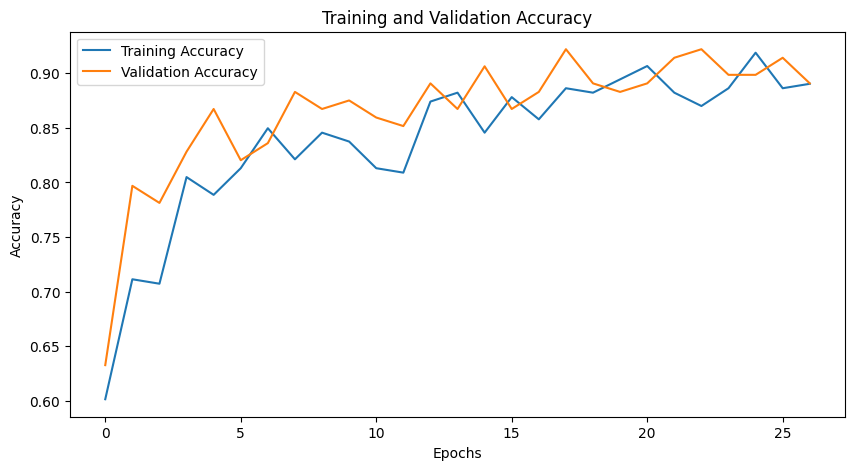

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

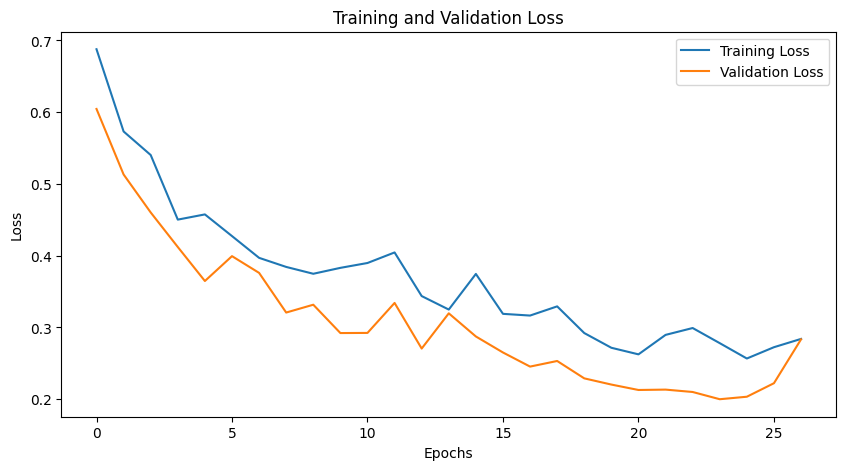

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

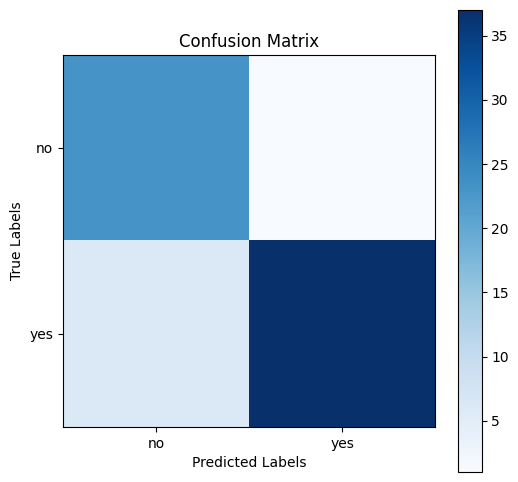

In [62]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1], test_data.class_indices.keys())
plt.yticks([0, 1], test_data.class_indices.keys())
plt.show()

In [63]:
model.save('/content/sample_data/my_model1.h5')
print("done")



done
